# 00 预告
<img src="https://s2.loli.net/2022/02/19/w7pbgVvONoA1U4I.png" width=70%>

# 04 数据操作 + 数据预处理

## 数据操作


## 数据操作实现
- 创建tensor
- 运算符运算$\rightarrow$逐个元素操作;逻辑运算符：X==Y 二元张量
- torch.cat(); x.sum() $\rightarrow$ 始终是一个张量，可设置维度
- 广播机制：3 * 1+1 * 2 $\rightarrow$3 * 2
- x[-1], x[1:3] 左闭右开，获取最后一个/XXX个元素
- id(Y)// Z[:]=X+Y, X+=Y
- A = X.numpy(), B = torch.tensor(A)
- a, a.item()

## 数据预处理
- 写数据
```python
import os 
os.makedirs(os.path.join('...', '...'), exist_ok=True)
path = os.path.join(os.path.join('', '', '...csv'))
with open(path, 'w') as f:
    f.write('this is a sentence\n')  # 可以设置列名，以及数据样本
```

- 读数据并预处理

```python
import pandas as pd
data = pd.read_csv('...csv')

input_data, output_data = data.iloc[:, 0:2], data.iloc[2] # iloc   
input_data = input_data.fillna(input_data.mean())   # fillna, mean
# 法二：类别值或离散值
input_data = pd.get_dummies(input_data, dummy_na=True)

print(data.values)
```



# 05 线性代数
## 线性代数实现
- 矩阵转置 A.T, A==A.T
- B = A.clone()
- 哈达玛积 A * B
- A.sum(axis=0//axis=[0, 1])   (2,5,4)->(5,4)//(4) 
- A.mean(), A.sum()/A.numel()  ||  A.mean(axis=0) ../A.shape[0]
- 保持维度：keepdim=True  $\rightarrow$ 保存维度从而***广播***
- A.cumsum(axis=0)
- torch.dot(x,y)
- torch.mv(A,x)//torch.mm(A,B)//torch.norm(u)、

## 按特定轴求和
keepdim $\rightarrow$ 1

# 06 矩阵运算
- 亚导数：将导数拓展到不可微的函数

<img src="https://s2.loli.net/2022/02/08/UFCj8LgbItqxh9z.png" width=40%>

- 梯度/偏导
- 标量$\rightarrow$向量：注意内积
$\frac{\partial y}{\partial \textbf{x}}$  $\leftarrow$ ***分子布局***
<img src="https://s2.loli.net/2022/02/08/m8k5rEZR1XD6H2u.png" width=70%>
- 向量求导
<img src="https://s2.loli.net/2022/02/08/BHMbOWntpSZIkrf.png" width=60%>

## 矩阵布局相关内容
相关重要公式：
$$\frac{\partial (\textbf x^T\textbf a)}{\partial \textbf x}=\frac{\partial (\textbf a^T\textbf x)}{\partial \textbf x}=\textbf a$$ 
$$\frac{\partial (\textbf x^T\textbf x)}{\partial \textbf x}=2\textbf x$$
<font color="#cf6923" size=4 face="黑体">不是很明白的推导：</font>
$$\frac{\partial(\textbf x^T\textbf A\textbf x)}{\partial \textbf x}=\textbf A\textbf x+\textbf A^T\textbf x$$






# 07 自动求导
## 自动求导
- 向量链式求导法则
- 自动求导
  - 符号求导/数值求导
  - 正向/反向 $\rightarrow$ 链式反则：【计算与内存复杂度】
- 计算图
  - 无环图：隐式构造/显式构造
  
## 自动求导实现
- **【注意】：标量求导**

```python
x.requires_grad(True)
x.grad
y = torch.dot(x, x)  #这里标量
y = x * x
y = y.sum()  #转化为标量 ## u=y.detach() 在保存参数中常用！分出计算图

y.backward()  
x.grad
```
- 控制流

## QA：
*梯度累加*：[掘金：梯度累加Gradient Accumulation](https://juejin.cn/post/7041121387418746910)  -->batch_size

# 08 线性回归+基础优化算法
## 线性回归
- 凸函数-->梯度0***最***优解
- 显式解//NPC问题

## 基础优化算法
- 梯度下降：沿反梯度方向更新参数求解
 - 超参数：学习率
 - 小批量随机梯度下降：超参数：批量大小
 
## 线性回归从0实现

In [31]:
## 流水线、模型、损失函数、优化器(小批量随机梯度下降)、（训练）
%matplotlib inline
import numpy as np
import torch 
import d2l.torch as d2l
import random
# ---------生成数据---------
def synthetic_data(w, b, num):
    X = torch.normal(0, 1, (num, len(w)))
    y = torch.matmul(X, w) + b        ## 我猜想这里有广播机制
    #y = torch.mul(w, X) + b   ## 这个确确实实用了广播，mul与matmul
                                # 我是脑残，区别mm,matmul,mul(对应位)
    
    y +=torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
ture_b = 4.2
feats, labels = synthetic_data(true_w, ture_b, 1000)
# 绘图展示
d2l.set_figsize()
# d2l.plt.scatter(feats[:,1].detach().numpy(), labels.detach().numpy(), 1)
#d2l.plt.show()

# --------读取小批量--------
def data_iter(batch_size, feats, labels):  ## 切片使用，转化list
    num = len(feats)   # len与shape不同
    indices = list(range(num))
    random.shuffle(indices)
    for i in range(0, num, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num)])
        yield feats[batch_indices], labels[batch_indices] ## 需要在函数里

batch_size = 10                                     ## 生成器
for X, y in data_iter(batch_size, feats, labels):   ## 这里它是迭代器！
   # print(X,'\n',y)
    break

# 初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  ##需要梯度哦
b = torch.zeros(1, requires_grad=True)
# --------定义模型--------
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

# ------定义损失函数-------
def squared_loss(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape))**2 / 2

# ------定义优化算法--------
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# --------训练------------
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, feats, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()     # 需要对向量累加
        sgd([w, b], lr, batch_size)  # 可能batch不能整除
    
    with torch.no_grad():
        train_l = loss(net(feats, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045818
epoch 2, loss 0.000183
epoch 3, loss 0.000052


- [Pytorch中的广播机制](https://blog.csdn.net/qq_42890800/article/details/115558389)
- 广播：
  - mul:对应位不同才可broadcast
  - matmul:
    - (2,5,3)×(1,3,4)-->(2,5,4) 
    - (5,3,4)×(4,2)-->(5,3,2) ; (2,1,3,4)×(5,4,2)-->(2,5,3,2) 最外：batch
  

## 线性回归的简洁实现

In [5]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
import torch.nn as nn

true_w = torch.tensor([2, -3.4])
ture_b = 4.2
feats, labels = d2l.synthetic_data(true_w, ture_b, 1000)
print('----------')
print(feats)

def load_array(data_arrays, batch_size, is_train=True): ## 注意这里的使用
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)   ## 以及这里的*：作用于可迭代对象
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((feats,labels), batch_size)

for data in data_iter:
    print('---------------')
    print(data)

    
# next(iter(data_iter))    ## iter：生成迭代器

# net = nn.Sequential(nn.Linear(2,1))

# net[0].weight.data.normal_(0, 0.01)  ##初始化 单层网络因此可以直接索引
# net[0].bias.data.fill_(0)

# loss = nn.MSELoss()
# trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# num_epochs = 3
# for epoch in range(num_epochs):
#     for X, y in data_iter:
#         l = loss(net(X), y)
#         trainer.zero_grad()
#         l.backward()
#         trainer.step()
#     l = loss(net(feats), labels)
#     print(f'epoch {epoch + 1}, loss {l:f}')

----------
tensor([[ 0.6364, -0.2699],
        [ 0.8885,  0.5589],
        [ 0.2375,  1.5755],
        ...,
        [-0.4887, -0.5486],
        [-0.8089,  0.1564],
        [-0.1770,  1.9138]])
---------------
[tensor([[-0.6318, -0.0919],
        [ 1.5754,  0.2078],
        [-0.1164,  0.4759],
        [ 0.2420, -0.6593],
        [ 0.2448,  0.3614],
        [ 0.3636,  0.3045],
        [-0.3006,  0.6859],
        [ 1.5126,  0.0446],
        [-1.2847,  0.5420],
        [ 2.1005,  1.1867]]), tensor([[ 3.2523],
        [ 6.6294],
        [ 2.3482],
        [ 6.9333],
        [ 3.4617],
        [ 3.8878],
        [ 1.2768],
        [ 7.0818],
        [-0.2302],
        [ 4.3627]])]
---------------
[tensor([[ 1.4120,  1.5849],
        [-0.8478, -1.7627],
        [ 0.2573, -2.4222],
        [ 0.8154, -0.2647],
        [ 0.0941,  1.0384],
        [ 0.8885,  0.5589],
        [ 1.5134, -0.5289],
        [ 0.4915,  1.9502],
        [-0.6139, -0.1207],
        [ 0.1109, -0.9904]]), tensor([[ 1.6326]

- 梯度下降时，注意除以batch_size，避免由于这个参数导致的数值差异过大；或者让lr来除调节学习率
- 合理初始化/Adam 
- batch_size：小则更利于收敛--->噪音，鲁棒
  - 更新：batch中每一个样本对应参数求梯度求和取平均值更新
- 一阶导向量，二阶导梯度/矩阵；  
   - 统计模型与优化模型-->收敛速度快与泛化性等无关；saddle point
- load可能存在内存爆掉；硬盘与内存，prefetch
- SGD：本质原因：NPC，没有显示解，导数为0；batch逐一逼近

# 09 softmax回归+损失函数+图片分类数据集
## softmax回归
- 从回归到多类分类
- 分类
  - 均方损失
    - 对类别一位有效编码
    - 均方损失训练
  - 无校验比例
    $O_y - O_i >= \Delta(y,i)$
  - 校验比例
     - 匹配概率，softmax，概率区别
- softmax与交叉熵损失: 预测置信度
 $$l(\textbf{y},\hat{\textbf{y}}) = -\sum_{\substack{i}}y_i\log{\hat{y}_i} = -\log{\hat{y}_y}$$
 
## 损失函数
损失函数，似然函数，导数
- L2 Loss: 
- L1 Loss：梯度常数，权重更新稳定
- Huber's Robust Loss
$\rightarrow$ 依据距离远近，函数、梯度形状

## 图像分类数据集

In [1]:
#### 这个代码块没有具体实现所以不能运行 不要运行不然报一堆错
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import d2l.torch as d2l

d2l.use_svg_display()    ## 使用svg， 据说图像更加清晰
"""加载数据集"""
trans = transforms.ToTensor()       ##-----这里 转化
mnist_train = torchvision.datasets.MNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvisionhvision.datasets.MNIST(
root="../data", train=False, transform=trans, download=True)

len(mnist_test),len(mnist_train)
mnist_train[0][0].shape

"""绘制"""
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat',
        'sandal', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
    
def show_images(img, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplot(num_rows, num_cols, figsize)
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)

"""图像与标签"""
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels)   

"""批量读取"""
batch_size = 256

def get_dataloder_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloder_workers())#训练集随机
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'              #  使用计时器什么的

"""函数定义"""
def load_data_fashion_mnist(batch_size, resize=None):
    """下载数据集并加载到内存中"""
    trans = [transforms.ToTensor()]       # 注意transforms的使用，处理图像
    if resize:                                    # 直到这里才第一次理解到transforms到底是在干啥，组合操作
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)
    
    return(data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloder_workers),
          data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloder_workers))

KeyboardInterrupt: 

## softmax回归从零开始实现

In [ ]:
## 这个也没有实现
import torch
import numpy as np
from IPython import display 
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs = 784    # 28*28
num_outputs = 10

"""初始化参数"""
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition    # 广播机制

"""实现softmax回归"""
def net(X):                     # 由于reshape感觉这个地方变得有点怪只能说
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)   # 好了我现在理解了，应该是：图片个数×784 (原先纠结于特征)

"""实现交叉熵损失函数"""
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])   ## 注意这个用法，很奇妙的

"""计算预测正确的数量"""
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

.  
"""计算在指定数据集上模型的精度"""
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):  # 这个东西是区别于model.train()和model.eval()的
        # 将模型设置为评估模型
        net.eval()  
    # 正确预测数、预测总数
    metric = Accumulator(2)      # 具体累加器实现，感觉挺好用的
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Accumulator:
    def _init_(self, n):
        self.data = [0.0] * n
    
    def add(self, *arg):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def _getitem_(self, idx):
        return self.data[idx]

    
evaluate_accuracya(net, test_ite r)

"""训练"""
def train_epoch_ch3(net, train_iter, loss, update):  ## 这次代码中很多判断这种
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(update, torch.optim.Optimizer):
            update.zero_grad()
            l.backward()
            update.step()
            metric.add(
               float(l) * len(y), accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            l.sum().backward()
            update(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.size().numel())
    
    return metric[0] / metric[2], metric[1] / metric[2]


def train_ch3(net, train_iter, test_iter, loss, num_epochs, update):
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, update)
        test_acc = evaluate_accuracy(net, test_iter)
    
    train_loss, train_acc = train_metrics


lr = 0.1
def update(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs,update)

"""PS部分"""
# sum求和注意keepdim=True，保持维度

In [35]:
import torch
import numpy as np
from torchvision import transforms
from d2l import torch as d2l

a = torch.tensor([[1, 2, 3], [2, 3, 4]])
# a.size().numel()
#batch_size = 256
#train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# next(iter(train_iter))
# image = torch.tensor(next(iter(train_iter)))

# image = image.cpu().clone()
# image = image.squeeze(0) # 压缩一维
# image = transforms.ToPILImage(image) # 自动转换为0-255

## softmax回归的简洁实现


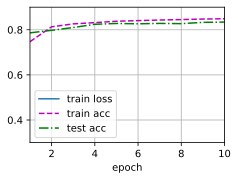

In [37]:
import torch
import torch.nn as nn
import d2l.torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

"""搭建网络"""           ## 这里注意
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10)) ##展平向量

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)     # 设置模型参数

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

- softlabel
- logistic regression 逻辑回归
- 交叉熵，相对熵，互信息
- 似然函数

# 10 多层感知机+代码实现
## 感知机
- 二分类：-1/1
 - 回归：实数
 - softmax回归：概率
 
- 训练感知机
   - 损失函数：$l(y,\textbf{x},\textbf{w}) = max(0, -y<\textbf{w}, \textbf{x}>)$  批量大小为1的梯度下降

- 收敛定理
  - 数据在r内
  - 余量：$y(\textbf{x}^T+\textbf{b})\ge \rho$ （有限制条件）
  - 感知机保证在$\frac{r^2+1}{\rho^2}$步后收敛

- XOR问题：感知机不能拟合XOR函数，只能产生线性分割面


## 多层感知机

- 单隐藏层
  - 非线性激活函数必须有：避免层数塌陷
<img src="https://s2.loli.net/2022/02/09/aTU8mSJv5OhHi2I.png" width=70%>
  - sigmoid
  - tanh
  - ReLU

- 多类分类
<img src="https://s2.loli.net/2022/02/09/MnVRhjbkA3yGcLo.png" width=70%>
- 多隐藏层
  - 超参数：隐层层数与隐藏层大小
  - 选择：128-64-32-8-输出 (底层可以先expand)

## 代码实现

In [ ]:
import torch
import torch.nn as nn
import d2l.torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_sizeh_size)

num_inputs, num_hiddens, num_outputs = 784, 256, 10
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True))
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]   # 用nn.Parameter设定网络参数

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)  ##居然能比较大小属于是太牛了

def net(X):
    X = X.reshape((-1,num_inputs))  ## reshape遗漏
    H = relu(X @ W1 + b1)           ## @：简写
    return (H @ W2 + b2)

loss = nn.CrossEntropyLoss()
epoch, lr = 10, 0.1
trainer = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_itera, test_iter, loss, epoch, trainer)


In [ ]:
import torch
import torch.nn as nn
import d2l.torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_sizeh_size)

net = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight)

loss = nn.CrossEntropyLoss()
epoch, lr = 10, 0.1
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_itera, test_iter, loss, epoch, trainer)


- svm与mlp、多层mlp
- "深度学习"与"浅度学习"：理论上一样，实际一般深度较好
- relu：引入非线性
- 鲁棒、泛化、稳定性

# 11 模型选择 + 过拟合和欠拟合
## 模型选择
- 训练误差$\rightarrow$训练数据 和 泛化误差$\rightarrow$新数据
- 验证数据集$\rightarrow$评估模型好坏 和 测试数据集$\rightarrow$只用一次的数据集
  - 验证：不要和训练混在一起；常拿出50%的训练数据
  - 测试只能用一次！（举例数据：虚高）
- K-折交叉验证
  - 非大数据集上
  - validation与train
  - k个验证的精度/误差平均得loss
     - 极端算法：尽可能使用数据集：n个数据，n折交叉验证

## 过拟合和欠拟合
- 过拟合和欠拟合
  - 模型容量||数据 $\rightarrow$ 正常/过拟合/欠拟合
    - 过拟合：没有泛化性
- 模型复杂度
  - 模型容量：
    - 拟合各种函数的能力
    - 最优情况：泛化误差最小，训练误差还行
      - 有时会选择承受一定的过拟合
    - 估计模型容量：同种类算法：①参数个数 ②参数值范围 -->控制复杂度
  - 统计学习：VC维
     - 支持n维输入的感知机的VC维是N+1
- 数据复杂度
  - 个数，时空结构，多样性
- 两个复杂度需要匹配
 

## 代码

# 12 权重衰退
处理过拟合
- 使用均方误差范数作为硬性限制
 - $\textbf{w}的L2 Loss\le \theta$; 更强的正则项
- 使用均方误差作为柔性限制
  $$minL(\textbf{w},b) + \frac{\lambda}{2}\textbf{w}的L2 Loss$$
  - 超参数$\lambda$控制了正则项的重要程度
    - $\lambda$ = 0：无作用
    